In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
veracityDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv")

In [4]:
veracityDf.head(3)

,source,label
0,adweek,0
1,airwars,0
2,bangkokpost,0


In [5]:
ownership = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/ownership/infoboxUNCOwnership.csv").rename(columns={"ogName":"source"})

In [10]:
ownership.head(1)

,Unnamed: 0,source,pName,search result,WikiOwner,UNCOwner,mergedOwner,cleanedOwner
0,0,andalusiastarnews,andalusia star news,Andalusia Star News,Boone Newspapers,Boone Newspapers,Boone Newspapers,Boone Newspapers


In [16]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/prohttps://eribean.github.io/girth/docs/quickstart/quickstart/jects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"])

<ipython-input-16-0d2084b2e61c>:6: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv(IN_PATH, sep="\t")


In [17]:
merged.head(1)

,Unnamed: 0,key,local_id,sourcedomain_id,date,title,content,url,fips,source,...,predrt_12,predrt_3,national,id,author,published,published_utc,collection_utc,year,clustNum
2,2,2,andalusiastarnews--2020-04-04--Governor issues...,andalusiastarnews-andalusiastarnews.com,2020-04-04,Governor issues stay at home order,Governor Kay Ivey announced that a stay at hom...,https://www.andalusiastarnews.com/2020/04/03/g...,1039.0,andalusiastarnews,...,44.15,30.8,False,NaN,NaN,NaN,NaN,NaN,2020,7.0


In [18]:
#bring in the ownership info 
merged = pd.merge(merged, ownership[["source", "search result", "cleanedOwner"]], on="source", how="left")

#bring in veracity labels 
merged = pd.merge(merged, veracityDf, on="source", how="left")

In [20]:
#bring in topic information 
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/doc_topics.txt", sep="\t")
docTopics.columns = ["index", "key"] + ["Topic" + str(i) for i in range(40)]
merged = pd.merge(merged, docTopics, on="key", how="left")

In [61]:
clustSizes = merged[["clustNum", "national"]].groupby("clustNum").agg(len).rename(columns={"national":"clustSize"}).reset_index()
merged = pd.merge(merged, clustSizes, on="clustNum", how="left")

In [62]:
merged = merged[merged["clustSize"] < 3000]

## H1: do papers owned by conglomerates spread more mis/dis-info 

In [24]:
merged = merged.rename(columns={"label":"veracityLabel"})

In [63]:
#first we need to get % coverage for each story cluster
clustVeracities = merged.dropna(subset="veracityLabel")[["veracityLabel","clustNum"]].groupby("clustNum").agg(np.mean).reset_index()
clustVeracities = clustVeracities.rename(columns={"veracityLabel":"clustVeracity"})

<Axes: xlabel='clustVeracity', ylabel='Density'>

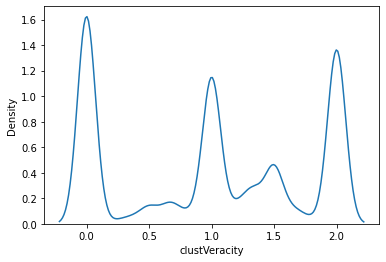

In [64]:
#look at the distribution of cluster-averaged veracity labels 
sns.kdeplot(clustVeracities["clustVeracity"])

In [65]:
"""
0 - Reliable 
1 - Mixed
2 - Unreliable 
"""

# merge the cluster-level average veracity
# clusters with no veracity score don't matter/count
# only want to look at local papers, since we are intersted in ownership / overlap w / national 
vLabeled = pd.merge(merged, clustVeracities, on="clustNum", how="left").dropna(subset = "clustVeracity")
vLabeled = vLabeled[vLabeled["national"] == False]

In [222]:
#now we need to assign labels based on the ownership of local papers 
#figure out which outlets are owned by larger firms
ownershipCounts = ownership[["source", "cleanedOwner"]].groupby("cleanedOwner").agg(len).sort_values("source", ascending=False)
ownershipCounts = ownershipCounts[ownershipCounts["source"] >= 2]
topOwners = list(ownershipCounts.index)

vLabeled["largeOwner"] = vLabeled["cleanedOwner"].isin(topOwners)

In [223]:
ownershipCounts

,source
cleanedOwner,
Gannett,34
Boone Newspapers,13
Forum Communications,10
Digital First Media,10
Sound Publishing,9
AIM Media,7
Black Press Group,5
Morris Multimedia,5
Champion Media,4


In [234]:
34 / 313

0.10862619808306709

Text(0.5, 0, '<-- More reliable           Less Reliable -->')

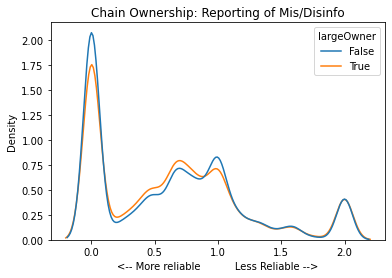

In [224]:
sns.kdeplot(x="clustVeracity", hue="largeOwner", common_norm=False, data=vLabeled)
plt.title("Chain Ownership: Reporting of Mis/Disinfo")
plt.xlabel("<-- More reliable           Less Reliable -->")

Text(0.5, 0, '<-- More reliable           Less Reliable -->')

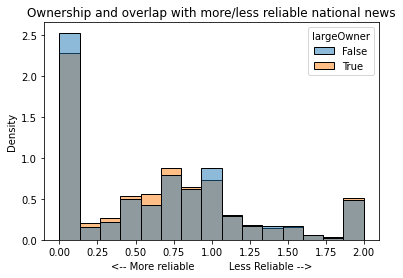

In [227]:
sns.histplot(x="clustVeracity", hue="largeOwner", common_norm=False, stat="density", bins = 15, data=vLabeled)
plt.title("Ownership and overlap with more/less reliable national news")
plt.xlabel("<-- More reliable           Less Reliable -->")

In [108]:
print(f'Large Owner Mis/Disinfo Mean: {np.mean(vLabeled.loc[vLabeled["largeOwner"] == True, "clustVeracity"])}')
print(f'Large Owner Mis/Disinfo Median: {np.median(vLabeled.loc[vLabeled["largeOwner"] == True, "clustVeracity"])}')

print(f'Non Large Owner Mis/Disinfo Mean: {np.mean(vLabeled.loc[vLabeled["largeOwner"] == False, "clustVeracity"])}')
print(f'Non Large Owner Mis/Disinfo Median: {np.median(vLabeled.loc[vLabeled["largeOwner"] == False, "clustVeracity"])}')

print(f'from {len(vLabeled)} total articles and {len(vLabeled["clustNum"].unique())} unique clusters')

Large Owner Mis/Disinfo Mean: 0.6513315244768965
Large Owner Mis/Disinfo Median: 0.6538461538461539
Non Large Owner Mis/Disinfo Mean: 0.6293244935866673
Non Large Owner Mis/Disinfo Median: 0.6395759717314488
from 113490 total articles and 26970 unique clusters


In [109]:
vLabeled["GannettOwns"] = vLabeled["cleanedOwner"] == "Gannett"

Text(0.5, 1.0, 'Ownership and overlap with more/less factual national news')

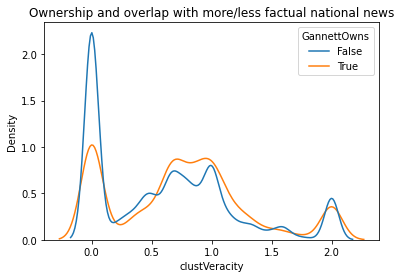

In [115]:
sns.kdeplot(x="clustVeracity", hue="GannettOwns", common_norm=False, data=vLabeled)
plt.title("Ownership and overlap with more/less factual national news")

Text(0.5, 1.0, 'Ownership and overlap with more/less factual national news')

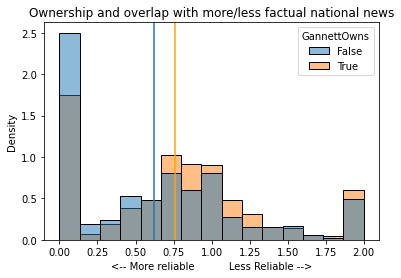

In [238]:
sns.histplot(x="clustVeracity", hue="GannettOwns", common_norm=False, stat="density", bins = 15, data=vLabeled)
plt.xlabel("<-- More reliable           Less Reliable -->")
plt.axvline(.757, color="orange")
plt.axvline(.622)
plt.title("Ownership and overlap with more/less factual national news")

In [112]:
print(f'Gannett Mis/Disinfo Mean: {np.mean(vLabeled.loc[vLabeled["GannettOwns"] == True, "clustVeracity"])}')
print(f'Gannett Mis/Disinfo Median: {np.median(vLabeled.loc[vLabeled["GannettOwns"] == True, "clustVeracity"])}')

print(f'Non-Gannett Mis/Disinfo Mean: {np.mean(vLabeled.loc[vLabeled["GannettOwns"] == False, "clustVeracity"])}')
print(f'Non-Gannett Mis/Disinfo Median: {np.median(vLabeled.loc[vLabeled["GannettOwns"] == False, "clustVeracity"])}')

print(f'from {len(vLabeled)} total articles and {len(vLabeled["clustNum"].unique())} unique clusters')

Gannett Mis/Disinfo Mean: 0.757612228578956
Gannett Mis/Disinfo Median: 0.751207729468599
Non-Gannett Mis/Disinfo Mean: 0.6221517970142101
Non-Gannett Mis/Disinfo Median: 0.625
from 113490 total articles and 26970 unique clusters


## H2: which topics are more/less common in large-owner papers  

In [127]:
## first we want to get average topic distributions at the cluster level 
topicCols = ["Topic" + str(i) for i in range(40)]
topicAverages = merged[["clustNum"] + topicCols].groupby("clustNum").agg(np.mean).reset_index()

topicAverages = pd.merge(merged[["clustNum", "national", "cleanedOwner"]], topicAverages, on="clustNum").reset_index()

In [128]:
topicAverages.head(3)

,index,clustNum,national,cleanedOwner,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,...,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39
0,0,29486.0,False,NaN,0.009153,0.003136,0.170972,0.001801,0.000753,0.003009,...,0.003762,0.165354,0.001357,0.010601,0.001775,0.001934,0.001376,0.011579,0.015661,0.000753
1,1,29486.0,False,NaN,0.009153,0.003136,0.170972,0.001801,0.000753,0.003009,...,0.003762,0.165354,0.001357,0.010601,0.001775,0.001934,0.001376,0.011579,0.015661,0.000753
2,2,29486.0,False,Boone Newspapers,0.009153,0.003136,0.170972,0.001801,0.000753,0.003009,...,0.003762,0.165354,0.001357,0.010601,0.001775,0.001934,0.001376,0.011579,0.015661,0.000753


In [129]:
#now we need to assign labels based on the ownership of local papers 
#figure out which outlets are owned by larger firms
ownershipCounts = ownership[["source", "cleanedOwner"]].groupby("cleanedOwner").agg(len).sort_values("source", ascending=False)
ownershipCounts = ownershipCounts[ownershipCounts["source"] >= 10]
topOwners = list(ownershipCounts.index)

topicAverages["largeOwner"] = topicAverages["cleanedOwner"].isin(topOwners)
topicAverages["GannettOwned"] = topicAverages["cleanedOwner"] == "Gannett"
ownershipCounts

,source
cleanedOwner,
Gannett,34
Boone Newspapers,13
Forum Communications,10
Digital First Media,10


In [251]:
#now we need to find the difference in average amount of cluster-averaged topics 
largeOwnerMean = topicAverages.loc[topicAverages["largeOwner"] == True, topicCols].apply(np.mean)
smallOwnerMean = topicAverages.loc[topicAverages["largeOwner"] == False, topicCols].apply(np.mean)
topicDiffs = pd.DataFrame(largeOwnerMean - smallOwnerMean).reset_index().rename(columns={"index":"topicNum", 0:"meanDiff"}).sort_values("meanDiff", ascending=False)

In [252]:
topicWords = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/topic_keys.txt", sep="\t", names=["topicNum", "rand", "words"])
topicWords["topicNum"] = "Topic" + topicWords["topicNum"].astype(str)

In [253]:
wordsMerged = pd.merge(topicDiffs, topicWords, on="topicNum", how="inner").drop(columns=["rand"])
wordsMerged.head(10)

,topicNum,meanDiff,words
0,Topic2,0.098993,game season team games players play coach foot...
1,Topic13,0.049077,it’s don’t time people we’re that’s make i’m w...
2,Topic38,0.039555,city county board council public meeting town ...
3,Topic14,0.023110,family years church home wife died john funera...
4,Topic1,0.022942,cases covid deaths county state health number ...
5,Topic37,0.020152,p.m event community year a.m day online events...
6,Topic9,0.018092,school students schools university education c...
7,Topic31,0.013497,people state masks coronavirus social health d...
8,Topic26,0.013124,health covid care coronavirus hospital medical...
9,Topic3,0.012968,water park animals river lake area dog animal ...


In [254]:
wordsMerged.tail(10)

,topicNum,meanDiff,words
30,Topic19,-0.014911,coronavirus cases country people virus travel ...
31,Topic36,-0.016415,investigation case fbi department attorney int...
32,Topic0,-0.017402,league season club united players team game ba...
33,Topic22,-0.021445,israel government people country israeli minis...
34,Topic11,-0.022060,news media twitter facebook video social post ...
35,Topic8,-0.022174,trump president biden white house donald admin...
36,Topic24,-0.023231,show film music series star love year story mo...
37,Topic23,-0.023767,people world political power america governmen...
38,Topic5,-0.025989,government people johnson lockdown london mini...
39,Topic15,-0.032781,iran russia russian military u.s forces war ir...


In [161]:
list(topicWords.loc[topicWords["topicNum"] == "Topic13","words"])

['it’s don’t time people we’re that’s make i’m work lot things good back there’s didn’t they’re he’s can’t doesn’t day ']

In [248]:
#now we need to find the difference in average amount of cluster-averaged topics 
GannettMean = topicAverages.loc[topicAverages["GannettOwned"] == True, topicCols].apply(np.mean)
nonGannettMean = topicAverages.loc[topicAverages["GannettOwned"] == False, topicCols].apply(np.mean)
topicDiffs = pd.DataFrame(GannettMean - nonGannettMean).reset_index().rename(columns={"index":"topicNum", 0:"meanDiff"}).sort_values("meanDiff", ascending=False)

In [249]:
wordsMerged = pd.merge(topicDiffs, topicWords, on="topicNum", how="inner")
wordsMerged.head(10)

,topicNum,meanDiff,rand,words
0,Topic38,0.042663,0.125,city county board council public meeting town ...
1,Topic37,0.037518,0.125,p.m event community year a.m day online events...
2,Topic1,0.037376,0.125,cases covid deaths county state health number ...
3,Topic9,0.031028,0.125,school students schools university education c...
4,Topic31,0.030583,0.125,people state masks coronavirus social health d...
5,Topic26,0.030472,0.125,health covid care coronavirus hospital medical...
6,Topic13,0.029460,0.125,it’s don’t time people we’re that’s make i’m w...
7,Topic6,0.025921,0.125,million money workers tax federal pay pandemic...
8,Topic14,0.017241,0.125,family years church home wife died john funera...
9,Topic3,0.011130,0.125,water park animals river lake area dog animal ...


In [250]:
wordsMerged.tail(10)

,topicNum,meanDiff,rand,words
30,Topic8,-0.015268,0.125,trump president biden white house donald admin...
31,Topic27,-0.017014,0.125,people time don family n't back life day told ...
32,Topic22,-0.019016,0.125,israel government people country israeli minis...
33,Topic11,-0.020389,0.125,news media twitter facebook video social post ...
34,Topic24,-0.023460,0.125,show film music series star love year story mo...
35,Topic5,-0.023881,0.125,government people johnson lockdown london mini...
36,Topic23,-0.025016,0.125,people world political power america governmen...
37,Topic0,-0.027702,0.125,league season club united players team game ba...
38,Topic15,-0.030186,0.125,iran russia russian military u.s forces war ir...
39,Topic2,-0.036129,0.125,game season team games players play coach foot...


## H3: Does usage of AP change with different owners? 

In [171]:
#get the AP labels imported 
apLabels = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fromAP/APLabels.tsv", sep="\t")

In [174]:
apDf = pd.merge(merged, apLabels, on="key", how="left")

In [198]:
apDf["largeOwner"] = apDf["cleanedOwner"].isin(topOwners)
apDf["GannettOwned"] = apDf["cleanedOwner"] == "Gannett"
ownershipCounts

<ipython-input-198-002ec5172d3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apDf["largeOwner"] = apDf["cleanedOwner"].isin(topOwners)
<ipython-input-198-002ec5172d3b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apDf["GannettOwned"] = apDf["cleanedOwner"] == "Gannett"


,source
cleanedOwner,
Gannett,34
Boone Newspapers,13
Forum Communications,10
Digital First Media,10


In [199]:
apDf["fromAP"] = apDf["fromAP"].fillna(False)

<ipython-input-199-d3e6d5df0224>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apDf["fromAP"] = apDf["fromAP"].fillna(False)


In [200]:
np.mean(apDf.loc[apDf["largeOwner"] == False, "fromAP"])
np.mean(apDf.loc[apDf["largeOwner"] == True, "fromAP"])

0.06078871133538922

Text(0.5, 1.0, 'Ownership and Assoc. Press Coverage')

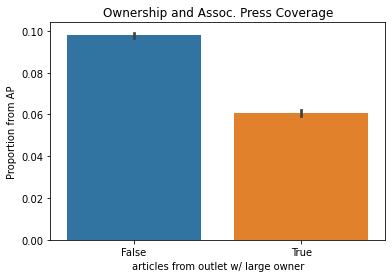

In [257]:
sns.barplot(x="largeOwner", y="fromAP",estimator=np.mean, n_boot=1000, data=apDf)
plt.ylabel("Proportion from AP")
plt.xlabel("articles from outlet w/ large owner")
plt.title("Ownership and Assoc. Press Coverage")

Text(0.5, 1.0, 'Ownership and Assoc. Press Coverage')

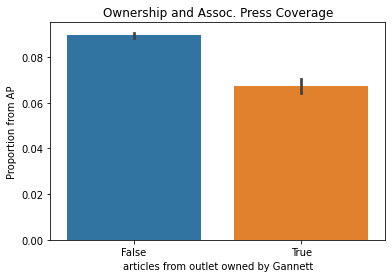

In [258]:
sns.barplot(x="GannettOwned", y="fromAP",estimator=np.mean, n_boot=1000, data=apDf)
plt.ylabel("Proportion from AP")
plt.xlabel("articles from outlet owned by Gannett")
plt.title("Ownership and Assoc. Press Coverage")

In [204]:
#now do it at the story cluster level 
apStoryDf = pd.merge(merged, apLabels, on="key", how="left")

In [205]:
apStoryDf["fromAP"] = apStoryDf["fromAP"].fillna(False)

In [210]:
#if we have one story from AP, we say the entire thing came from AP 
storyAPLabs = apStoryDf[["clustNum", "fromAP"]].groupby("clustNum").agg(lambda x: sum(x) > 0).reset_index()
storyAPLabs = storyAPLabs.rename(columns={"fromAP":"clustFromAP"})

In [212]:
apStoryDf = pd.merge(apStoryDf, storyAPLabs, on="clustNum", how="left")

In [214]:
apStoryDf["largeOwner"] = apStoryDf["cleanedOwner"].isin(topOwners)
apStoryDf["GannettOwned"] = apStoryDf["cleanedOwner"] == "Gannett"

Text(0.5, 1.0, 'Ownership and Assoc. Press Coverage')

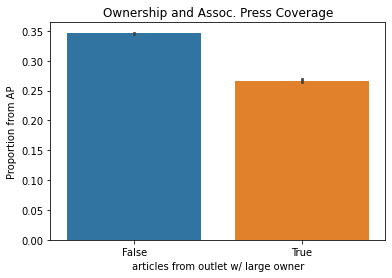

In [259]:
sns.barplot(x="largeOwner", y="clustFromAP",estimator=np.mean, n_boot=1000, data=apStoryDf)
plt.ylabel("Proportion from AP")
plt.xlabel("articles from outlet w/ large owner")
plt.title("Ownership and Assoc. Press Coverage")

Text(0.5, 1.0, 'Ownership and Assoc. Press Coverage')

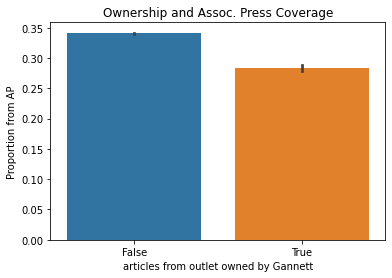

In [260]:
sns.barplot(x="GannettOwned", y="clustFromAP",estimator=np.mean, n_boot=300, data=apStoryDf)
plt.ylabel("Proportion from AP")
plt.xlabel("articles from outlet owned by Gannett")
plt.title("Ownership and Assoc. Press Coverage")